In [258]:
import pandas as pd
from pathlib import Path

# Preprocessing / Checking Data

In [259]:
# path to the csv file(data)
data_path = Path("../data/training-dataset.csv")


In [260]:
#reading the csv file ... most of the time there is issue with the text type that is why I put encoding 'utf-8'

df = pd.read_csv(data_path, encoding="utf-8")

In [261]:
#checking top rows 
df.head()

,note_id,text,label
0,N2013,Patient reports flooding during menses since m...,1
1,N2015,Patient reports heavy menses since stopping OC...,1
2,N2022,"Patient reports HMB for the past 6 months, des...",1
3,N2042,Patient no menorrhagia; menses reported as reg...,0
4,N2030,Patient bleeding within normal limits; menses ...,0


In [262]:

# the shape of file ( num of rows and columns)
# list the name of columns

print(" Shape (rows, cols):", df.shape)
print(" Columns:", list(df.columns))

 Shape (rows, cols): (50, 3)
 Columns: ['note_id', 'text', 'label']


In [263]:
#Checking how many missing values each column has
null_fraction = df.isna().mean().sort_values(ascending=False)
display(null_fraction.head(10))

note_id    0.0
text       0.0
label      0.0
dtype: float64

In [264]:
# counting exact duplicate rows
dup_count = df.duplicated().sum()

print(f" Duplicate rows: {dup_count}")

 Duplicate rows: 0


In [265]:
# checking if label column is 0/1 all of them 
print("Unique (raw):", pd.unique(df['label']))

Unique (raw): [1 0]


In [266]:
# if we had longer and larger dataset 
#checking if texts are empty or whitespaced

s = df['text'].astype(str)
s_norm = s.str.replace(r"\s+", " ", regex=True).str.strip()

empty_mask = df['text'].isna() | s_norm.eq("")
print("Empty/whitespace-only texts:", int(empty_mask.sum()))
df.loc[empty_mask, ['note_id','text']].head(10) if empty_mask.any() else print(" None found")


Empty/whitespace-only texts: 0
 None found


In [267]:
len(df[df['label'] == 1 ]) # number of classes 1 


26

In [268]:
len(df[df['label'] == 0]) # number of classes 0


24

In [269]:
df = df[["text", "label"]].dropna()   
df.head()

,text,label
0,Patient reports flooding during menses since m...,1
1,Patient reports heavy menses since stopping OC...,1
2,"Patient reports HMB for the past 6 months, des...",1
3,Patient no menorrhagia; menses reported as reg...,0
4,Patient bleeding within normal limits; menses ...,0


## 2.	Tokenize the text field using a Hugging Face model (e.g., `bert-base-uncased`).

In [270]:

import numpy as np

from datasets import Dataset


In [271]:
from sklearn.model_selection import train_test_split

#splitting train_val with stratify so it is balanced
train_df, val_df = train_test_split(
    df,
    test_size=0.3,
    random_state=46,
    stratify=df["label"],
)
train_df

,text,label
9,Patient bleeding within normal limits; menses ...,0
39,Patient reports heavy menstrual bleeding worse...,1
15,Patient no flooding or pad saturation; menses ...,0
17,Patient bleeding within normal limits; menses ...,0
13,Patient reports heavy menstrual bleeding since...,1
3,Patient no menorrhagia; menses reported as reg...,0
31,Patient denies heavy bleeding; menses reported...,0
48,Patient reports menorrhagia since stopping OCP...,1
12,Patient no evidence of heavy periods; menses r...,0
45,Patient reports very heavy periods worsened in...,1


In [272]:
from transformers import AutoTokenizer

In [273]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

max_length = 128

In [274]:

train_enc = tokenizer(train_df["text"].astype(str).tolist(),truncation=True,padding="max_length",max_length=max_length)

val_enc = tokenizer(val_df["text"].astype(str).tolist(),truncation=True,padding="max_length",max_length=max_length)



In [291]:
# Torch Dataset / DataLoader
from torch.utils.data import Dataset, DataLoader

class E_dataset(Dataset):
    def __init__(self, enc, labels):
        self.enc = enc
 
        self.labels = np.asarray(labels, dtype=np.int64).tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return {
            "input_ids": torch.tensor(self.enc["input_ids"][i], dtype=torch.long),
            "attention_mask": torch.tensor(self.enc["attention_mask"][i], dtype=torch.long),
            "labels": torch.tensor(self.labels[i], dtype=torch.long),
        }
train_ds = E_dataset(train_enc, train_df["label"])
val_ds   = E_dataset(val_enc,   val_df["label"])
# creating dataloaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)


## 3.	Train a small classifier (e.g., `distilbert-base-uncased`) for 1–2 epochs.

In [297]:
import torch
from torch.optim import AdamW
## for future of the project , if data becomes large do we have gpu available or not 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

## Loaded a pretrained DistilBERT with a 2-class (0/1) classification head 
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

opt = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)


Device: cpu


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [298]:
from transformers import  AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score


In [308]:

def evaluate(model, loader, device):
    
    model.eval()
    
    all_preds, all_labels = [], []
    
    total_loss, steps = 0.0, 0
    
    with torch.no_grad(): # no gradients needed during evaluation
        for batch in loader:              
            # move tensors to the same device as the model
            batch = {k: v.to(device) for k, v in batch.items()}
            
            out = model(**batch)
            
            total_loss += float(out.loss); steps += 1
            
             # converting logits  predicted class index (0 or 1)
            preds  = out.logits.argmax(dim=-1).detach().cpu().numpy()
            
            # grabing ground-truth labels
            labels = batch["labels"].detach().cpu().numpy()
            
            all_preds.extend(preds.tolist())
            
            all_labels.extend(labels.tolist())
            
    return {
        "loss": total_loss / max(1, steps),
        "accuracy": accuracy_score(all_labels, all_preds),
        "f1": f1_score(all_labels, all_preds, average="weighted"),
        "cm": confusion_matrix(all_labels, all_preds, labels=[0,1]),
    }


In [309]:

epochs = 2


for epoch in range(1, epochs + 1):
    model.train()
    running = 0.0 # running average of training loss in this epoch

    # collect train metrics across the epoch
    train_preds, train_labels = [], []

    for step, batch in enumerate(train_loader, start=1): # step batch counter
        
        batch = {k: v.to(device) for k, v in batch.items()}

        opt.zero_grad(set_to_none=True)        # clear grads 
        
        out = model(**batch)                    # forward: returns loss and logits 
        #print(out)
        loss = out.loss
        
        loss.backward()                         # backprop
        
        opt.step()                              # updating weights
        

        running += loss.item()

        # accumulate predictions/labels for train metrics
        preds = out.logits.argmax(dim=-1).detach().cpu().tolist()
        
        #print(preds)
        
        labels = batch["labels"].detach().cpu().tolist()
        
        #print(labels)
        
        train_preds.extend(preds)
        
        train_labels.extend(labels)

        if step % 5 == 0 or step == len(train_loader): # print every 5
            
            print(f"Epoch {epoch} Step {step}/{len(train_loader)} | Avg Train Loss {running/step:.4f}")

    # compute train metrics
    train_acc = accuracy_score(train_labels, train_preds)
    
    train_f1  = f1_score(train_labels, train_preds, average="weighted")
    

    # validation metrics 
    val = evaluate(model, val_loader, device)
    print(
        f"[Epoch {epoch}] "
        f"Train Acc {train_acc:.4f} | Train F1 {train_f1:.4f} || "
        f"Val Loss {val['loss']:.4f} | Val Acc {val['accuracy']:.4f} | Val F1 {val['f1']:.4f}"
    )


final = evaluate(model, val_loader, device)
print("\nValidation Accuracy:", round(final['accuracy'], 4))
print("Validation F1:", round(final['f1'], 4))



Epoch 1 Step 5/5 | Avg Train Loss 0.1037
[Epoch 1] Train Acc 1.0000 | Train F1 1.0000 || Val Loss 0.0707 | Val Acc 1.0000 | Val F1 1.0000
Epoch 2 Step 5/5 | Avg Train Loss 0.0757
[Epoch 2] Train Acc 1.0000 | Train F1 1.0000 || Val Loss 0.0539 | Val Acc 1.0000 | Val F1 1.0000

Validation Accuracy: 1.0
Validation F1: 1.0


## Confusion matrix 

[[5 0]
 [0 5]]


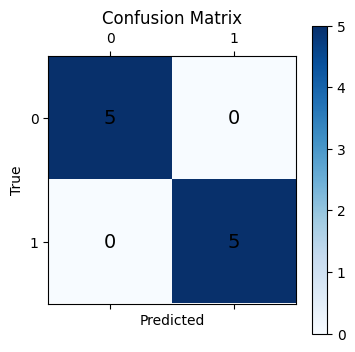

In [296]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names=[0,1], title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(4,4))
    cax = ax.matshow(cm, cmap=plt.cm.Blues) 
    plt.title(title)
    fig.colorbar(cax)

    ax.set_xticks(range(len(class_names)))
    
    ax.set_yticks(range(len(class_names)))
    
    ax.set_xticklabels(class_names)
    
    ax.set_yticklabels(class_names)
    
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")


    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f"{val}", ha="center", va="center", color="black", fontsize=14)

    plt.show()

print(final["cm"]) 
plot_confusion_matrix(final["cm"], class_names=[0,1])



# ADDING CROSS VALIDATION 

In [290]:
from sklearn.model_selection import StratifiedKFold


n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=34)

fold_acc, fold_f1 = [], []  

for fold, (tr_idx, va_idx) in enumerate(skf.split(df["text"], df["label"]), start=1):
    print(f"\n ------------- Fold {fold}/{n_splits}------------")


    train_df = df.iloc[tr_idx].reset_index(drop=True)
    
    val_df   = df.iloc[va_idx].reset_index(drop=True)

    train_enc = tokenizer(train_df["text"].astype(str).tolist(),truncation=True, padding="max_length", max_length=128)
    
    val_enc = tokenizer(val_df["text"].astype(str).tolist(),truncation=True, padding="max_length", max_length=128)


    train_ds = E_dataset(train_enc, train_df["label"])
    
    val_ds   = E_dataset(val_enc,   val_df["label"])
    
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    
    val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)


    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)
    
    opt = AdamW(model.parameters(), lr=1e-3, weight_decay=0.01) 

    def evaluate_current():
        model.eval()
        all_preds, all_labels = [], []
        total_loss, steps = 0.0, 0
        
        with torch.no_grad():
            
            for batch in val_loader:
                
                batch = {k: v.to(device) for k, v in batch.items()}
                
                out = model(**batch)
                
                total_loss += out.loss.item(); steps += 1
                
                preds  = out.logits.argmax(dim=-1).detach().cpu().numpy()
                
                labels = batch["labels"].detach().cpu().numpy()
                
                all_preds.extend(preds); all_labels.extend(labels)
                
        avg_loss = total_loss / max(1, steps)
        
        acc = accuracy_score(all_labels, all_preds)
        
        f1  = f1_score(all_labels, all_preds, average="weighted")
        
        return {"loss": avg_loss, "accuracy": acc, "f1": f1,
                "y_true": all_labels, "y_pred": all_preds}

    epochs = 2
    for epoch in range(1, epochs + 1):
        model.train()
        running = 0.0
        train_preds, train_labels = [], []

        for step, batch in enumerate(train_loader, start=1):
            batch = {k: v.to(device) for k, v in batch.items()}

            opt.zero_grad(set_to_none=True)
            out = model(**batch)
            loss = out.loss
            loss.backward()
            opt.step()

            running += loss.item()
            
            # collecting train metrics
            
            preds  = out.logits.argmax(dim=-1).detach().cpu().tolist()
            
            labels = batch["labels"].detach().cpu().tolist()
            
            train_preds.extend(preds); train_labels.extend(labels)

            if step % 5== 0 or step == len(train_loader): print(f"[Fold {fold} | Epoch {epoch} | Step {step}/{len(train_loader)}] "f"Avg Train Loss {running/step:.4f}")


        tr_acc = accuracy_score(train_labels, train_preds)
        
        tr_f1  = f1_score(train_labels, train_preds, average="weighted")


        
        val = evaluate_current()

        
        print(f"[Fold {fold} | Epoch {epoch}] "f"Train Acc {tr_acc:.4f} | Train F1 {tr_f1:.4f} || "f"Val Loss {val['loss']:.4f} | Val Acc {val['accuracy']:.4f} | Val F1 {val['f1']:.4f}")

    # record this fold’s results
    fold_acc.append(val["accuracy"]); fold_f1.append(val["f1"])

    # confusion matrix per fold 
    cm = confusion_matrix(val["y_true"], val["y_pred"], labels=[0, 1])
    print(f"[Fold {fold}] Confusion matrix (rows=true, cols=pred):\n{cm}")





 ------------- Fold 1/5------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Fold 1 | Epoch 1 | Step 5/5] Avg Train Loss 0.7718
[Fold 1 | Epoch 1] Train Acc 0.5000 | Train F1 0.4987 || Val Loss 0.6380 | Val Acc 0.6000 | Val F1 0.4500
[Fold 1 | Epoch 2 | Step 5/5] Avg Train Loss 0.9266


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Fold 1 | Epoch 2] Train Acc 0.5000 | Train F1 0.4949 || Val Loss 0.6449 | Val Acc 0.6000 | Val F1 0.4500
[Fold 1] Confusion matrix (rows=true, cols=pred):
[[0 4]
 [0 6]]

 ------------- Fold 2/5------------
[Fold 2 | Epoch 1 | Step 5/5] Avg Train Loss 0.7655
[Fold 2 | Epoch 1] Train Acc 0.5750 | Train F1 0.5325 || Val Loss 0.8015 | Val Acc 0.5000 | Val F1 0.3333
[Fold 2 | Epoch 2 | Step 5/5] Avg Train Loss 0.6893


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Fold 2 | Epoch 2] Train Acc 0.6250 | Train F1 0.5739 || Val Loss 0.5260 | Val Acc 1.0000 | Val F1 1.0000
[Fold 2] Confusion matrix (rows=true, cols=pred):
[[5 0]
 [0 5]]

 ------------- Fold 3/5------------
[Fold 3 | Epoch 1 | Step 5/5] Avg Train Loss 0.9487
[Fold 3 | Epoch 1] Train Acc 0.4000 | Train F1 0.3520 || Val Loss 0.6793 | Val Acc 0.5000 | Val F1 0.3333
[Fold 3 | Epoch 2 | Step 5/5] Avg Train Loss 0.8265


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Fold 3 | Epoch 2] Train Acc 0.4000 | Train F1 0.4000 || Val Loss 0.6812 | Val Acc 0.5000 | Val F1 0.3333
[Fold 3] Confusion matrix (rows=true, cols=pred):
[[0 5]
 [0 5]]

 ------------- Fold 4/5------------
[Fold 4 | Epoch 1 | Step 5/5] Avg Train Loss 0.9431
[Fold 4 | Epoch 1] Train Acc 0.5500 | Train F1 0.5500 || Val Loss 0.6977 | Val Acc 0.5000 | Val F1 0.3333
[Fold 4 | Epoch 2 | Step 5/5] Avg Train Loss 0.7405


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Fold 4 | Epoch 2] Train Acc 0.3750 | Train F1 0.3690 || Val Loss 0.6574 | Val Acc 0.5000 | Val F1 0.3333
[Fold 4] Confusion matrix (rows=true, cols=pred):
[[5 0]
 [5 0]]

 ------------- Fold 5/5------------
[Fold 5 | Epoch 1 | Step 5/5] Avg Train Loss 0.7838
[Fold 5 | Epoch 1] Train Acc 0.5750 | Train F1 0.5325 || Val Loss 0.8277 | Val Acc 0.5000 | Val F1 0.3333
[Fold 5 | Epoch 2 | Step 5/5] Avg Train Loss 0.7216
[Fold 5 | Epoch 2] Train Acc 0.4750 | Train F1 0.4740 || Val Loss 0.6843 | Val Acc 0.5000 | Val F1 0.3333
[Fold 5] Confusion matrix (rows=true, cols=pred):
[[0 5]
 [0 5]]
